In [1]:
import sys
sys.path.append("../../src")

import torch
from systems import System_ANI
from integrator import maxwell_boltzmann
import torchani
import numpy as np
import nglview as nv

import ase
from ase.io import read

import cProfile
import pstats

import matplotlib.pyplot as plt

# np.random.seed(0)
# torch.manual_seed(0)

# Load alanine dipeptide structure, get some properties

In [2]:
# structure = sys.argv[1]
structure = 'dialaB.pdb'

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Device = {device}')
precision = torch.float32

model = torchani.models.ANI1ccx(periodic_table_index=True).to(device) # ASE

# Load pdb file into ase Atoms object
alanine_ase = ase.Atoms(read(structure))

# Construct System_ANI from ase Atoms object
system_ani = System_ANI.from_ase(alanine_ase, device=device)

system_ani.set_velocities(maxwell_boltzmann(system_ani.masses, T=300, replicas=1, device=device))
print(f'Kinetic energy: {system_ani.get_kinetic_energy()}eV')
print(f'Temperature: {system_ani.get_temperature()}K')
print(f'Dihedrals psi: {system_ani.get_dihedrals_ani()[0, 0]}rad, phi: {system_ani.get_dihedrals_ani()[0, 1]}rad')
print(f'Position = {system_ani.get_positions()}')

Device = cpu
Kinetic energy: 0.8119708299636841eV
Temperature: 285.5313154156269K
Dihedrals psi: 0.13115854561328888rad, phi: 1.1571578979492188rad
Position = tensor([[[20.9300, 14.7800, 10.1200],
         [19.8500, 14.7700,  9.9600],
         [19.5600, 15.7500, 10.3100],
         [19.3500, 13.9400, 10.4500],
         [19.6500, 14.6900,  8.4500],
         [20.6000, 15.0600,  7.7600],
         [18.4600, 14.3500,  7.9600],
         [17.7600, 14.0900,  8.6400],
         [18.1100, 14.4500,  6.5600],
         [17.0400, 14.2400,  6.6200],
         [18.2100, 15.8900,  6.0500],
         [17.6900, 16.4600,  6.8200],
         [19.2400, 16.2500,  5.9800],
         [17.6700, 16.0500,  5.1200],
         [18.8500, 13.5300,  5.6000],
         [18.7100, 13.6700,  4.3900],
         [19.6400, 12.6100,  6.1700],
         [19.6600, 12.5400,  7.1800],
         [20.3700, 11.5700,  5.4700],
         [21.3600, 11.4500,  5.9100],
         [19.9200, 10.5800,  5.5600],
         [20.4500, 11.7300,  4.4000]]], req

# Minimise structure

In [3]:
from minimizers import minimize_pytorch_lbfgs_ANI
minimize_pytorch_lbfgs_ANI(system_ani, steps=1000)
print(system_ani.pos)


Iter 	 E (eV)  		 E (a.u.)  		 fmax  
   0   -13478.557254728921  -495.327843016827    2.647284269333
   1   -13478.271602514747  -495.317345491578    8.628445625305
   2   -13478.769732174893  -495.335651418944    1.548684239388
   3   -13478.805356135545  -495.336960575351    1.143454909325
   4   -13478.871764232656  -495.339401027907    1.038920760155
   5   -13478.914946363799  -495.340987941956    0.943170905113
   6   -13478.923177633162  -495.341290435526    1.826653003693
   7   -13478.954391579746  -495.342437526905    0.755817294121
   8   -13478.959898015113  -495.342639884673    0.317854106426
   9   -13478.964969774581  -495.342826268395    0.299194276333
  10   -13478.973765473846  -495.343149504381    0.527714908123
  11   -13478.975970480880  -495.343230536895    1.104480147362
  12   -13478.984561817593  -495.343546262696    0.282701998949
  13   -13478.987742412513  -495.343663147404    0.232265859842
  14   -13478.992643869857  -495.343843272639    0.364363163710
  

# Set up Integrator

In [4]:
# ---------- Torchani ---------
from integrator import Langevin_integrator
from ase.units import eV, Hartree, kB

langevin_temperature = 300  # K
langevin_gamma = 0.2
timestep = 1  # fs
# height=0.004336  # standard =metady
height=0.052 # well-tempered
width=0.05


integrator_ani = Langevin_integrator(system_ani, timestep, device, fr=langevin_gamma, temp=langevin_temperature, height=height, width=width)


# Run simulation

In [5]:
n_iter = int(1e4) # 10 ps simulation takes ~ 10 min
print_iter = 1 # print trajectory and log every timestep
append = False

# --------- Standard MD -------------
# integrator_ani.run(n_iter, traj_file='log/' + structure.split('.')[0] + '.xyz', log_file='log/' + structure.split('.')[0] + '.csv', log_interval=print_iter, device=device, metadyn=None, dTemp=None)

# ---------- Standard metad ------------
# integrator_ani.run(n_iter, traj_file='log/' + structure.split('.')[0] + '.xyz', log_file='log/' + structure.split('.')[0] + '.csv', log_interval=print_iter, device=device, metadyn=True, dTemp=None)

# ----------- Well-tempered metad ------------
integrator_ani.run(n_iter, traj_file='log/' + structure.split('.')[0] + '.xyz', log_file='log/' + structure.split('.')[0] + '.csv', log_interval=print_iter,device=device, metadyn='well-tempered', metadyn_func=system_ani.get_dihedrals_ani, dTemp=8*langevin_temperature, append=append)


100%|██████████| 10000/10000 [11:06<00:00, 15.00it/s]


# Import data

In [6]:
import pandas as pd, matplotlib.pyplot as plt
df = pd.read_csv('log/' + structure.split('.')[0] + '.csv', skiprows=1)
df

,Epot,Ekin,Etot,Phi,Psi,Temp
0,-612.686099,0.036908,-612.649192,1.040129,0.673910,285.531315
1,-612.681482,0.030690,-612.650792,1.051780,0.668289,237.431567
2,-612.673379,0.024942,-612.648437,1.062610,0.662475,192.962569
3,-612.670774,0.024131,-612.646643,1.076076,0.654401,186.687135
4,-612.670764,0.022270,-612.648494,1.089274,0.646691,172.289745
...,...,...,...,...,...,...
9995,-612.649261,0.049289,-612.599972,1.434457,-0.820681,381.319953
9996,-612.652556,0.048381,-612.604175,1.423747,-0.817069,374.290479
9997,-612.657528,0.051512,-612.606016,1.411651,-0.812259,398.514993
9998,-612.659080,0.054166,-612.604914,1.398421,-0.806089,419.045875


# Plot dihedral angles in degrees

(-180.0, 180.0)

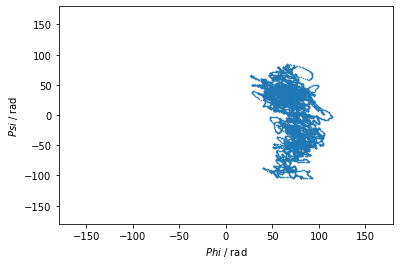

In [7]:
# Degrees

# plt.scatter(df['Phi'], df['Psi'], marker='.', s=1)
# plt.xlim(-np.pi, np.pi)
# plt.ylim(-np.pi, np.pi)

# Radian
plt.xlabel('$Phi$ / rad')
plt.ylabel('$Psi$ / rad')
plt.scatter(df['Phi']/np.pi * 180, df['Psi']/np.pi * 180, marker='.', s=1)
plt.xlim(-180, 180)
plt.ylim(-180, 180)


# View Trajectory

In [8]:
import nglview as nv
from ase.io import read
nv.show_asetraj(read('log/' + structure.split('.')[0] + '.xyz', index=':'), gui=True)

NGLWidget(max_frame=9999)